In [75]:
import torch
from transformers import BertTokenizer, BertModel, BertConfig
import numpy as np

from xai_transformer import BertAttention
from xai_transformer import LNargsDetach, LNargsDetachNotMean
from utils import LayerNorm

In [76]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,


In [77]:
text = "This movie was absolutely wonderful, I loved it."

In [78]:
encoding = tokenizer(text, return_tensors='pt')
input_ids = encoding["input_ids"].to(config.device)
print("Token IDs:", input_ids)

Token IDs: tensor([[ 101, 2023, 3185, 2001, 7078, 6919, 1010, 1045, 3866, 2009, 1012,  102]])


In [79]:
bert_config = BertConfig.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architec

In [80]:
embeddings = bert_model.embeddings.to(config.device)
embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [81]:
## we have replaced the LayerNorm by our custom no gradient implementation
from utils import LayerNorm
embeddings.LayerNorm = LayerNorm(bert_config.hidden_size,
                                 eps = bert_config.layer_norm_eps,
                                 args = LNargsDetach())

In [82]:
embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNormImpl()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [83]:
class SimpleConfig:
    hidden_size = bert_config.hidden_size
    all_head_size = bert_config.hidden_size
    num_attention_heads = bert_config.num_attention_heads
    attention_head_size = bert_config.hidden_size // bert_config.num_attention_heads
    n_blocks = 4
    n_classes = 2
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'cpu'
    train_mode = False

    # complete detached run
    detach_layernorm = True
    detach_mean = True
    detach_kq = True

    layer_norm_eps = 1e-5

    #
    lnv = 'nowb'
    sigma = None
    adanorm_scale = 1.
    nowb_scale = None
    layer_norm_eps = 1e-5

In [84]:
config = SimpleConfig()

In [85]:
config.device

'cpu'

In [86]:
model = BertAttention(config, embeddings).to(config.device)

print("\nModel initialized. Running baseline explanation...\n")

Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm
Detach K-Q-softmax branch
Detach LayerNorm Mean+Norm

Model initialized. Running baseline explanation...



In [87]:
# sanity check
for i, block in enumerate(model.attention_layers):
    print(i, "detach:", block.detach)

0 detach: True
1 detach: True
2 detach: True
3 detach: True


In [88]:
# debug check
print("Embedding LN:", type(embeddings.LayerNorm))
print("Embedding LN device:", embeddings.LayerNorm.weight.device)

print()
print("Block LN types:")
for i, block in enumerate(model.attention_layers):
    print(i, type(block.output.LayerNorm))

print()
print("Detach flags:")
print("detach_kq:", config.detach_kq)
print("detach_layernorm:", config.detach_layernorm)
print("detach_mean:", config.detach_mean)
print("device:", config.device)

Embedding LN: <class 'utils.LayerNormImpl'>
Embedding LN device: cpu

Block LN types:
0 <class 'utils.LayerNormImpl'>
1 <class 'utils.LayerNormImpl'>
2 <class 'utils.LayerNormImpl'>
3 <class 'utils.LayerNormImpl'>

Detach flags:
detach_kq: True
detach_layernorm: True
detach_mean: True
device: cpu


In [89]:
target_class = 1

result = model.forward_and_explain(
    input_ids=input_ids,
    cl=target_class,
    gammas = None
)

In [90]:
print(model.device)
print(next(model.parameters()).device)
print(embeddings.word_embeddings.weight.device)
print(input_ids.device)

cpu
cpu
cpu
cpu


In [91]:
result

{'loss': None,
 'logits': tensor([[-0.2360,  0.1233]], grad_fn=<AddmmBackward0>),
 'R': array([[ 0.17642671, -0.01933175, -0.00726074,  0.00111734, -0.03950717,
          0.01589655, -0.01543627, -0.02383288,  0.0014436 ,  0.00781577,
          0.01387691, -0.02099462]], dtype=float32)}

In [92]:
relevance = result["R"] # shape: [1, seq_len]
logits = result["logits"]

In [93]:
print("Relevance shape:", relevance.shape)
print("Logits:", logits)
print("Relevance:", relevance)

Relevance shape: (1, 12)
Logits: tensor([[-0.2360,  0.1233]], grad_fn=<AddmmBackward0>)
Relevance: [[ 0.17642671 -0.01933175 -0.00726074  0.00111734 -0.03950717  0.01589655
  -0.01543627 -0.02383288  0.0014436   0.00781577  0.01387691 -0.02099462]]


In [94]:
f_x = logits[0, target_class].item()
sum_relevance = float(np.sum(relevance))

print("Conservation Check\n")
print("Model output f(x): \n", f_x)
print()

print("Sum of relevance R(x_i):\n", sum_relevance)
print()

print("Difference:\n", abs(f_x - sum_relevance))
print()

Conservation Check

Model output f(x): 
 0.12330318987369537

Sum of relevance R(x_i):
 0.09021345525979996

Difference:
 0.033089734613895416



## Benchmarking on SST-2 Validation split

In [95]:
from datasets import load_dataset

dataset = load_dataset("glue", "sst2")
val_data = dataset["validation"]

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [96]:
val_data

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 872
})

In [97]:
texts = [example["sentence"] for example in val_data]
labels = [example["label"] for example in val_data]

In [98]:
texts[:2], labels[:2]

(["it 's a charming and often affecting journey . ",
  'unflinchingly bleak and desperate '],
 [1, 0])

### Completeness tests

In [100]:
import numpy as np
from tqdm import tqdm

conservation_errors = []
logits_list = []
relevance_sums = []

for text, label in tqdm(zip(texts, labels), total=len(texts)):
    enc = tokenizer(text, return_tensors='pt', truncation=True)
    input_ids = enc['input_ids'].to(config.device)

    result = model.forward_and_explain(
        input_ids=input_ids,
        cl=label,
        gammas=None
    )

    R = result["R"]  # shape (1, seq_len)
    logits = result["logits"][:, label].item()

    relevance_sum = float(np.sum(R))
    error = abs(logits - relevance_sum)

    conservation_errors.append(error)
    logits_list.append(logits)
    relevance_sums.append(relevance_sum)

100%|██████████| 872/872 [01:05<00:00, 13.26it/s]


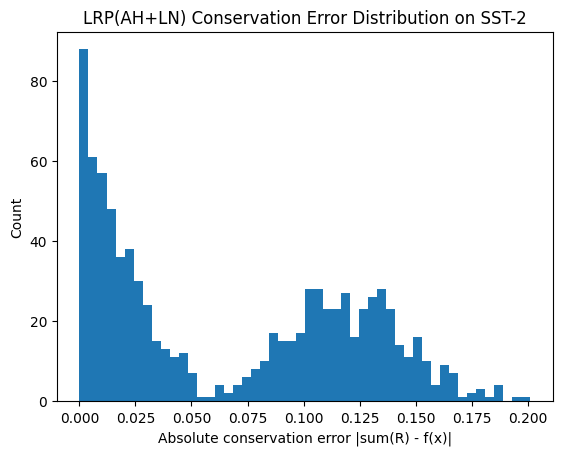

In [101]:
import matplotlib.pyplot as plt

plt.hist(conservation_errors, bins=50)
plt.xlabel("Absolute conservation error |sum(R) - f(x)|")
plt.ylabel("Count")
plt.title("LRP(AH+LN) Conservation Error Distribution on SST-2")
plt.show()

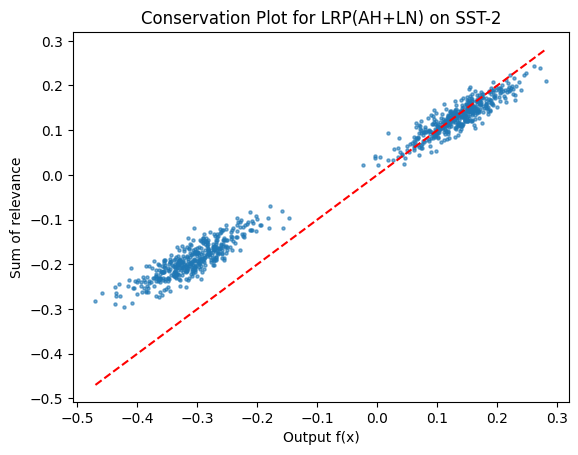

In [102]:
plt.scatter(logits_list, relevance_sums, s=5, alpha=0.6)
plt.plot([min(logits_list), max(logits_list)],
         [min(logits_list), max(logits_list)], 'r--')  # diagonal
plt.xlabel("Output f(x)")
plt.ylabel("Sum of relevance")
plt.title("Conservation Plot for LRP(AH+LN) on SST-2")
plt.show()

### Pertubtation Tests (AUAC and AU-MSE)

In [103]:
from utils import flip

fracs = np.linspace(0, 1, 20)
auac_list = []
aumse_list = []

for text, label in tqdm(zip(texts, labels), total=len(texts)):
    tokens = tokenizer.tokenize(text)
    enc = tokenizer(text, return_tensors='pt', truncation=True)
    input_ids = enc["input_ids"].to(config.device)

    result = model.forward_and_explain(input_ids, cl = label)
    R = result["R"].flatten()

    mse, evidence, _ = flip(
        model, R, input_ids, tokens, torch.tensor(label).to(config.device),
        fracs = fracs,
        flip_case = 'generate',
        tokenizer = tokenizer,
        device = config.device
    )

    auac = np.trapz(evidence, fracs)
    auac_list.append(auac)

    # For pruning
    mse, _, _ = flip(
        model, R, input_ids, tokens, torch.tensor(label).to(config.device),
        fracs = fracs,
        flip_case = 'pruning',
        tokenizer = tokenizer,
        device = config.device
    )

    aumse = np.trapz(mse, fracs)
    aumse_list.append(aumse)

  0%|          | 0/872 [00:00<?, ?it/s]/content/utils.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs0 = torch.tensor(token_ids).to(device)
/tmp/ipython-input-2307211033.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auac = np.trapz(evidence, fracs)
/tmp/ipython-input-2307211033.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aumse = np.trapz(mse, fracs)
100%|██████████| 872/872 [33:27<00:00,  2.30s/it]


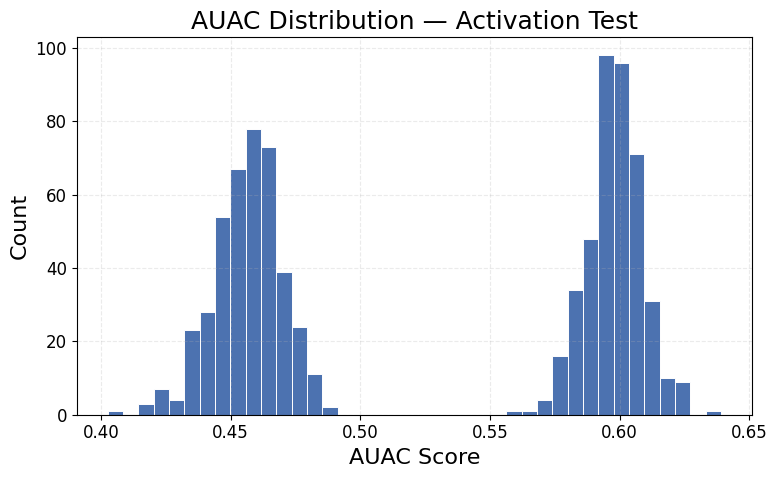

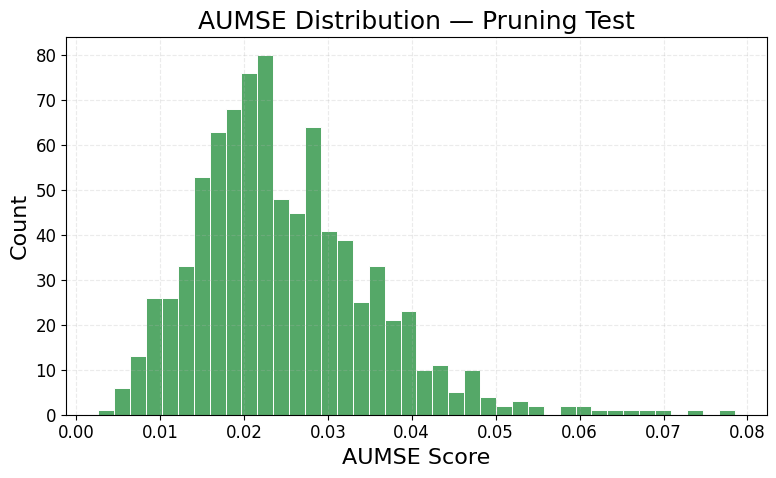

In [107]:
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (8, 5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
})

# AUAC Histogram
plt.figure()
plt.hist(auac_list, bins=40, color="#4C72B0", edgecolor="white", linewidth=0.7)
plt.title("AUAC Distribution — Activation Test")
plt.xlabel("AUAC Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# AUMSE Histogram
plt.figure()
plt.hist(aumse_list, bins=40, color="#55A868", edgecolor="white", linewidth=0.7)
plt.title("AUMSE Distribution — Pruning Test")
plt.xlabel("AUMSE Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()